In [51]:
import pandas as pd
import pickle
import random
from rdkit import Chem
import itertools
import torch
import numpy as np
from enhancement_utility import generate_smiles, smiles_to_fingerprint

seed = 12

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [52]:
df = pd.read_csv('Cernak_cleaned.csv', index_col=False)
print(df.head())
pickle_path = 'Cernak.pkl'

with open(pickle_path, 'rb') as file:
        model = pickle.load(file)

proxy_model = model.predict
THRESHOLD = 0.01

          Nucleophile                                           Catalyst  \
0   O=C(CC(OCC)=O)OCC  CC(C1=CC=CC2=C1O3)(C)C4=C3C([P+]([Pd-2]5([P+](...   
1        SC1=CC=CC=C1  Cl[Pd-2]1([P+](C(C)(C)C)(C(C)(C)C)C(C)(C)C)C2=...   
2        NC1=CC=CC=C1  CS(O[Pd-2]1([P+](C(C)(C)C)(C(C)(C)C)C2=CC=C(N(...   
3  NC(CC1=CC=CC=C1)=N  CC(C1=CC=CC2=C1O3)(C)C4=C3C([P+]([Pd-2]5([P+](...   
4        OC1=CC=CC=C1  CC(C)C1=CC(C(C)C)=CC(C(C)C)=C1C2=CC=CC=C2[P+](...   

                                        Base  Conversion  
0            CN(CCCN1C)P1(N(CC)CC)=NC(C)(C)C         0.0  
1                  CN(C)/C(N(C)C)=N\C(C)(C)C         0.0  
2                           CN1CCCN2C1=NCCC2         0.0  
3                  CN(C)/C(N(C)C)=N\C(C)(C)C         0.0  
4  CN(P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=CCC)C         0.0  


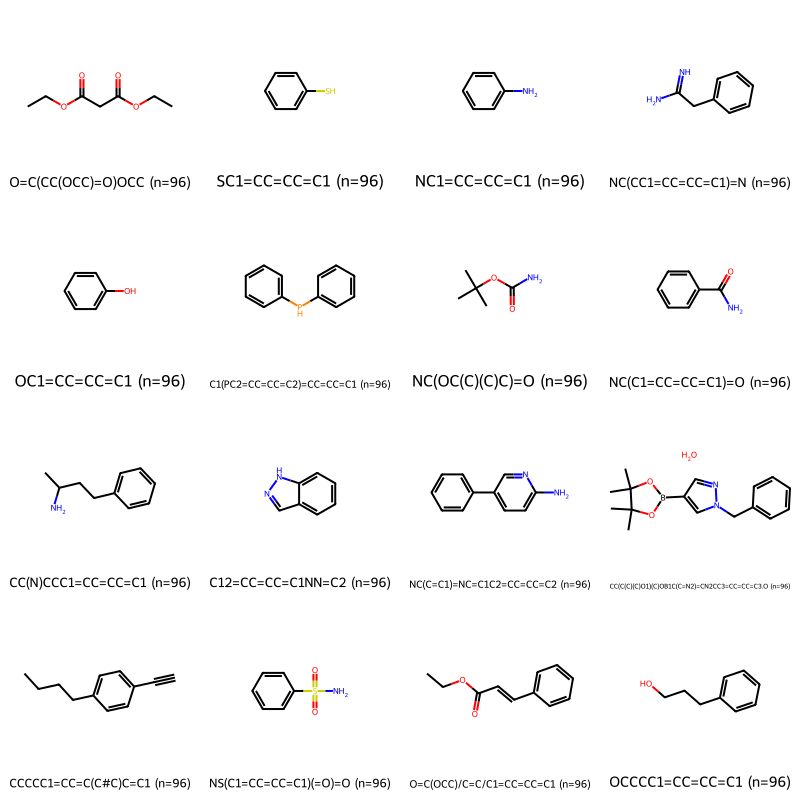

In [53]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

# Assuming df is your DataFrame and the column containing SMILES is called 'Nucleophile'

# Calculate the frequency of each unique SMILES
frequency = df['Nucleophile'].value_counts()

# Create a DataFrame with unique nucleophiles and their counts
unique_nucleophiles = pd.DataFrame({
    'Nucleophile': frequency.index,
    'Count': frequency.values
})

# Convert each unique SMILES to an RDKit Molecule object
unique_nucleophiles['Molecule'] = unique_nucleophiles['Nucleophile'].apply(Chem.MolFromSmiles)

# Prepare the list of molecules and the legends (SMILES + count)
mols = unique_nucleophiles['Molecule'].tolist()
legends = [f"{smi} (n={count})" for smi, count in zip(unique_nucleophiles['Nucleophile'], unique_nucleophiles['Count'])]

# Draw the molecules in a grid with the frequency in the legend
img = Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)

# Display the image within the Jupyter notebook
display(img)


In [54]:
nucleophiles = df['Nucleophile'].to_list()
random.shuffle(nucleophiles)
catalysts = list(set(df['Catalyst'].to_list()))
bases = list(set(df['Base'].to_list()))

nucleophiles_enhanced = []

In [55]:
for nucleophile in nucleophiles:
    nucleophiles_enhanced.extend(generate_smiles(nucleophile))

In [56]:
nucleophile_pattern = Chem.MolFromSmarts('[NH2]')
nucleophiles_filtered = []

for smi in nucleophiles_enhanced:
    mol = Chem.MolFromSmiles(smi)
    if mol.HasSubstructMatch(nucleophile_pattern):
        nucleophiles_filtered.append(smi)

nucleophiles_filtered = list(set(nucleophiles_filtered))
print(len(nucleophiles_filtered))

33


In [57]:
combinations = list(itertools.product(catalysts, bases, nucleophiles_filtered))
print(len(combinations), len(nucleophiles_filtered))
df_enhanced = pd.DataFrame(combinations, columns=['Catalyst', 'Base', 'Nucleophile'])
print(df_enhanced.head(), len(df_enhanced))

3168 33
                                            Catalyst  \
0  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
1  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
2  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
3  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
4  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   

                                   Base            Nucleophile  
0  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     CC(N)C[C+]c1ccccc1  
1  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     NS(=O)(=O)c1ccccc1  
2  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3  NS(=O)(=O)c1c[c-]ccc1  
3  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     N=C(N)Cc1[c-]cccc1  
4  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3        CC(C)(C)OC(N)=O   3168


In [58]:
fingerprints = []
for index, row in df_enhanced.iterrows():
    catalyst_fp = smiles_to_fingerprint(row['Catalyst'])
    base_fp = smiles_to_fingerprint(row['Base'])
    nucleophile_fp = smiles_to_fingerprint(row['Nucleophile'])

    concatenated_fp = torch.cat((catalyst_fp, base_fp, nucleophile_fp))
    fingerprints.append(concatenated_fp)
    
X = torch.stack(fingerprints)
print(X.shape)

y = proxy_model(X)
print(y.shape)

df_enhanced['Conversion'] = y

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Nucleophile'].unique()), len(df_enhanced['Catalyst'].unique()), len(df_enhanced['Base'].unique()))

torch.Size([3168, 3072])
(3168,)
                                            Catalyst  \
0  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
1  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
2  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
3  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
4  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   

                                   Base            Nucleophile  Conversion  
0  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     CC(N)C[C+]c1ccccc1    0.000030  
1  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     NS(=O)(=O)c1ccccc1    0.000008  
2  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3  NS(=O)(=O)c1c[c-]ccc1    0.000107  
3  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     N=C(N)Cc1[c-]cccc1    0.000112  
4  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3        CC(C)(C)OC(N)=O    0.001942   3168
33 16 6


In [59]:
mean_conversion = df_enhanced.groupby('Nucleophile')['Conversion'].mean()

nucleophiles_below_threshold = mean_conversion[mean_conversion < THRESHOLD].index

print(nucleophiles_below_threshold)

df_enhanced = df_enhanced[df_enhanced['Nucleophile'].isin(nucleophiles_below_threshold)]

print(df_enhanced.head(), len(df_enhanced))
print(len(df_enhanced['Nucleophile'].unique()), len(df_enhanced['Catalyst'].unique()), len(df_enhanced['Base'].unique()))

Index(['CC(C)(C)OC(N)=O', 'CC(C)(C)OC(N)=[O+]', 'CC(C)(C)O[C+](N)=O',
       'CC(C)(C)[O+]C(N)=O', 'CC(N)C[C+]c1ccccc1', 'CC(N)C[C-]c1ccccc1',
       'CC(N)[C-]Cc1ccccc1', 'N=C(N)Cc1[c-]cccc1', 'N=C(N)Cc1ccccc1',
       'N=C(N)[C+]c1ccccc1', 'NS(=O)(=O)c1[c-]cccc1', 'NS(=O)(=O)c1c[c-]ccc1',
       'NS(=[O+])(=[O+])c1ccccc1', 'N[C+](=O)c1ccccc1', '[C+]C(C)(C)OC(N)=O'],
      dtype='object', name='Nucleophile')
                                            Catalyst  \
0  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
2  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
3  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
4  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   
5  CC([P+](C1=C[CH-]C=C1)(C(C)(C)C)[Pd-2]2([P+](C...   

                                   Base            Nucleophile  Conversion  
0  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3     CC(N)C[C+]c1ccccc1    0.000030  
2  CC(C)(C)N=P(N1CCCC1)(N2CCCC2)N3CCCC3  NS(=O)(=O)c1c[c-]ccc1    0.000107  
3  CC(C)(C)N=P(N1CC

In [60]:
final_df = pd.concat([df, df_enhanced], ignore_index=True)

print(len(final_df), len(final_df['Nucleophile'].unique()), len(final_df['Catalyst'].unique()), len(final_df['Base'].unique()))

final_df.to_csv('Cernak_enhanced.csv', index=False)

2976 31 16 6
